@author: 孙采萱-398

要求：以谱聚类或者马尔科夫聚类对鸢尾花数据集进行处理，得到类似如下图所示（Normalized Cut），并输出正确率。
步骤：
1.计算距离矩阵（例如欧氏距离）
2.利用KNN计算邻接矩阵 AA
3.由 AA 计算度矩阵 DD 和拉普拉斯矩阵 LL
4.标准化 L→D−1/2LD−1/2L→D−1/2LD−1/2
5.对矩阵 D−1/2LD−1/2D−1/2LD−1/2 进行特征值分解，得到特征向量 HnnHnn
6.将 HnnHnn 当成样本送入 Kmeans 聚类
7.获得聚类结果 C=(C1,C2,⋯,Ck)
8.求预测准确率

In [1]:
import numpy as np
import scipy
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
#计算距离矩阵
def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S

In [3]:
#利用KNN计算带权邻接矩阵 A
def myKNN(S, k, sigma=2.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours

        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j] # mutually
    return A

In [4]:
#标准化的拉普拉斯矩阵
#由A计算度矩阵D和拉普拉斯矩阵L
def laplacian(A):
    """Computes the symetric normalized laplacian.
    L = D^{-1/2} A D{-1/2}
    """
    D = np.zeros(A.shape)
    w = np.sum(A, axis=0)
    D.flat[::len(w) + 1] = w ** (-0.5)  # set the diag of D to w
    return D.dot(A).dot(D)

In [5]:
#k-means
def k_means(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=2)
    return kmeans.fit(X).labels_

In [6]:
#谱聚类
def spectral_clustering(affinity, n_clusters, cluster_method=k_means):
    L = laplacian(affinity)
    eig_val, eig_vect = scipy.sparse.linalg.eigs(L, n_clusters)
    X = eig_vect.real
    rows_norm = np.linalg.norm(X, axis=1, ord=2)
    Y = (X.T / rows_norm).T
    labels = cluster_method(Y, n_clusters)
    return labels

In [7]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt

#引入数据集  根据邻接矩阵进行聚类 
    from sklearn import datasets
    iris = datasets.load_iris()
    data = np.array(iris.data)
    lable = np.array(iris.target)
    Similarity = calEuclidDistanceMatrix(data)
    Adjacent = myKNN(Similarity, k=10)
    Laplacian = laplacian(Adjacent)
    x, V = np.linalg.eig(Laplacian)
    x = zip(x, range(len(x)))
    x = sorted(x, key=lambda x:x[0])
    H = np.vstack([V[:,i] for (v, i) in x[:500]]).T
    sp_kmeans = k_means(H,n_clusters=3)
    pure_kmeans = k_means(data,n_clusters=3)

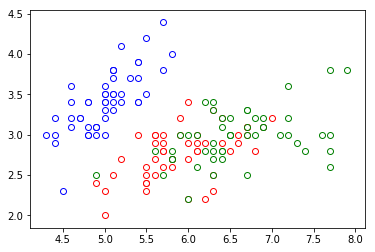

In [8]:
#将鸢尾花数据集画成图
for i in range(len(lable)):
    if lable[i] == 0:
        plt.scatter(data[i,0], data[i,1],c="w", edgecolors='b')
    elif lable[i] == 1:
        plt.scatter(data[i,0], data[i,1], c="w", edgecolors='r')
    else:
        plt.scatter(data[i,0], data[i,1], c="w", edgecolors='g')

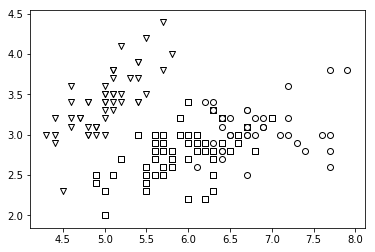

In [9]:
#将聚类结果可视化，重新转换成图的形式
#用圆圈、三角和矩阵表示各个簇
for i in range(len(data)):
    if pure_kmeans[i] == 0:
        plt.scatter(data[i,0], data[i,1],c="w", edgecolors='k', marker="v")  #三角
    elif pure_kmeans[i] == 1:
        plt.scatter(data[i,0], data[i,1], c="w", edgecolors='k', marker="s") #矩阵
    else:
        plt.scatter(data[i,0], data[i,1], c="w", edgecolors='k', marker="o") #圆圈

In [10]:
#求分簇准确率
score_pure = accuracy_score(lable,pure_kmeans)
print(score_pure)

0.8933333333333333


分析：鸢尾花样本中存在重复的样本点；
鸢尾花样本中有噪声点存在导致正确率不高；
谱聚类适用于球形分类，鸢尾花样本集不属于球形